In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Building the dataset.

In [6]:
block_size = 3 
X, Y = [], []

for w in words:
    context = [0] * block_size # How many characters do we want to take to predict the next one. 

    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] 

X = torch.tensor(X)
Y = torch.tensor(Y)
    

In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [8]:
C = torch.randn((27, 2))

In [9]:
C.dtype

torch.float32

In [10]:
C[5] # Use this as more concise.

tensor([ 0.9820, -0.9211])

In [11]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 0.9820, -0.9211])

In [12]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [228]:
# 6 because we have 3, 2 dimensional inputs. Second is the number of neurons which is up to us.
n = 100 # neurons
W1 = torch.rand((6, n))
b1 = torch.rand(n)

In [229]:
# We do negative one so pytorch will infer the shape.
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h


tensor([[-0.8098,  0.8213, -0.6573,  ...,  0.5940, -0.8843,  0.2299],
        [-0.4278,  0.7973,  0.2536,  ...,  0.5551, -0.6508,  0.8232],
        [-0.5718, -0.1264,  0.9187,  ..., -0.3616, -0.8576,  0.7503],
        ...,
        [-0.9892, -0.9834, -0.9911,  ..., -0.7097, -0.9750, -0.7001],
        [-0.9948, -0.9894, -0.9811,  ..., -0.9222, -0.9978, -0.9008],
        [-0.9250, -0.6956, -0.9911,  ...,  0.5599, -0.4244, -0.6608]])

In [230]:
W2 = torch.rand((n, 27))
b2 = torch.rand(27)

In [231]:
logits = h @ W2 + b2

In [232]:
counts = logits.exp()

In [233]:
prob = counts / counts.sum(1, keepdims=True)

In [234]:
prob.shape
prob[0].sum()

tensor(1.0000)

In [235]:
loss = -prob[torch.arange(32), Y].log().mean()

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [236]:
loss

tensor(0.2556, grad_fn=<NllLossBackward0>)

In [13]:
# -------------- Tidy Up -------------- #
X.shape, Y.shape # Dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [84]:
g = torch.Generator().manual_seed(2147483647) # for reproducability

C = torch.randn((27, 2), generator=g) # Random initial values
n = 100 # Number of neurons I want in hidden layer

W1 = torch.randn((6, n), generator=g) # Random weights, one for each letter and '.'
b1 = torch.randn(n, generator=g) # Random biases

W2 = torch.randn((n, 27), generator=g) # Random weights again, output layer is 27
b2 = torch.randn(27, generator=g) # Random 

parameters = [C, W1, b1, W2, b2]

In [85]:
sum(p.nelement() for p in parameters) # Number of parameters

3481

In [86]:
for p in parameters:
    p.requires_grad = True

In [99]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [95]:
lrei = []
lossi = []

# Forward pass
for i in range(10000):
    # Mini batch
    ix = torch.randint(0, X.shape[0], (32,))
    
    emb = C[X[ix]] # emb.shape = [32, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # We use view to get into desired shape (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(|1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y[ix]) 
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 10**-10
    for p in parameters:
        p.data += -lr * p.grad 

    ## Track stats
    # lrei.append(lre[i])
    # lossi.append(loss.item())
# print(loss.item())

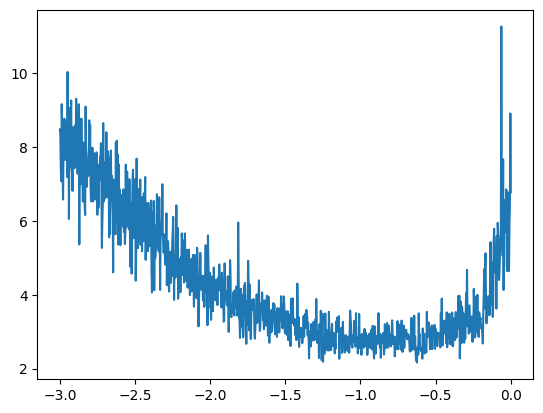

In [78]:
# plt.plot(lrei, lossi)

In [96]:
emb = C[X[ix]] # emb.shape = [32, 3, 2]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # We use view to get into desired shape (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y[ix]) 
loss

tensor(2.2487, grad_fn=<NllLossBackward0>)

In [145]:
# Train, dev/validation, test split (80:10:10)

def build_datatset(words):
    block_size = 3 
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size  
    
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] 
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_datatset(words[:n1])
Xdev, Ydev = build_datatset(words[n1:n2])
Xte, Yte = build_datatset(words[n2:])


torch.Size([182512, 3]) torch.Size([182512])
torch.Size([22860, 3]) torch.Size([22860])
torch.Size([22774, 3]) torch.Size([22774])


In [209]:
g = torch.Generator().manual_seed(2147483647) # for reproducability

C = torch.randn((27, 10), generator=g) # Random initial values
n = 200 # Number of neurons I want in hidden layer

W1 = torch.randn((30, n), generator=g) # Random weights, one for each letter and '.'
b1 = torch.randn(n, generator=g) # Random biases

W2 = torch.randn((n, 27), generator=g) # Random weights again, output layer is 27
b2 = torch.randn(27, generator=g) # Random 

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [188]:
sum(p.nelement() for p in parameters)

11897

In [189]:
lrei = []
lossi = []
stepi = []

In [198]:
# Forward pass
for i in range(50000):
    # Mini batch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    emb = C[Xtr[ix]] # emb.shape = [32, 3, 2]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # We use view to get into desired shape (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(|1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix]) 
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad 

    # Track stats
    # lri.append(lrei[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
    
# print(loss.item())

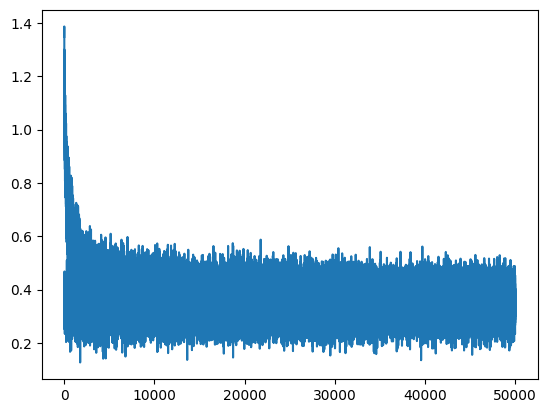

In [199]:
plt.plot(stepi, lossi)

In [200]:
emb = C[Xdev] # emb.shape = [32, 3, 2]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # We use view to get into desired shape (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev) 
loss

tensor(2.2020, grad_fn=<NllLossBackward0>)

In [201]:
emb = C[Xtr] # emb.shape = [32, 3, 2]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # We use view to get into desired shape (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr) 
loss

tensor(2.1734, grad_fn=<NllLossBackward0>)

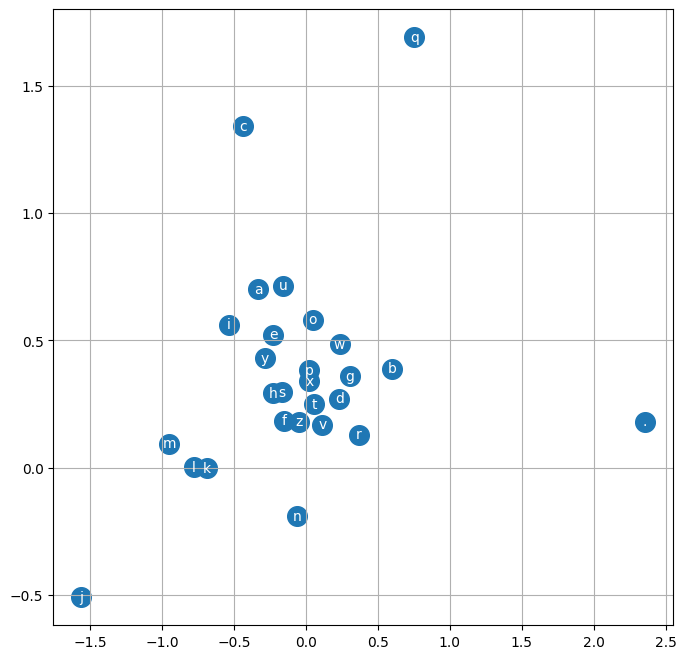

In [202]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [210]:
lossi = []
stepi = []

In [211]:
for i in range(200000):

    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # Forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # We use view to get into desired shape (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix]) 

    for p in parameters:
            p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    stepi.append(i)
    lossi.append(loss.log10().item())

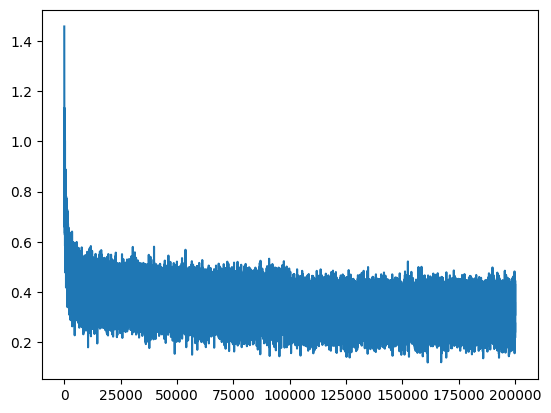

In [212]:
plt.plot(stepi, lossi)

In [213]:
emb = C[Xtr] # emb.shape = [32, 3, 2]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # We use view to get into desired shape (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr) 
loss

tensor(2.1254, grad_fn=<NllLossBackward0>)

In [214]:
emb = C[Xdev] # emb.shape = [32, 3, 2]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # We use view to get into desired shape (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev) 
loss

tensor(2.1677, grad_fn=<NllLossBackward0>)

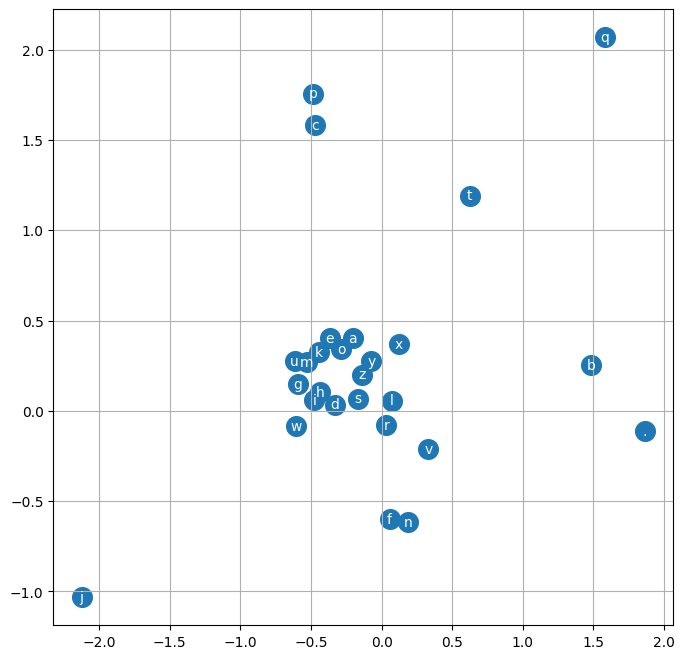

In [215]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [219]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carlah.
amelle.
khi.
mili.
thon.
halayseeja.
hutviyah.
rha.
kaeli.
nellara.
chaiia.
kaleigh.
ham.
joir.
quinton.
lilea.
jadiq.
waterri.
jarynix.
kael.


[0, 0, 0]